# Importing datasets from three different sources and merging them

### One of my favorite things about Python is the ability to pull data from anywhere. Whether it be from the internet, a SQL database, a CSV file from your computer, or out of thin air, Python isn't fazed by anything.

### I can't count how many times I've used SQL at work only to be limited by data existing outside of the warehouse. Sure, I can pull in the data onto our sandbox (which has limited storage) on a weekly basis, because that's how often it refreshes, and of course with the permission of our warehouse team. However, this is not often the best or fastest solution.

### In this post I will show you three ways of pulling in data within the same program and then cleaning and merging said data. I will use Bundesliga data varying from average attendance, league standings, and match outcomes. I will add new columns and categorize some of the data just for illustration purposes.

### Before we get started, let's import the necessary packages (This is always step 1 in Python)


In [87]:
import pandas as pd
import warnings
import wikipedia as wp
import numpy as np
import pymssql
import matplotlib.pyplot as plt
import sqlite3 # A number of folks have moved on to sqlalchemy as their preferred sql package, so be sure to look into that

warnings.filterwarnings('ignore')


## Part 1 - Import Data from CSV file

### I use pandas to read the csv and assign it the variable name "att". I also change the data type for one of the colums to integer.

In [70]:
att = pd.read_csv(r'C:\Users\tsakota\Documents\Halfway\Learn\Python_Tibor\buli1617attendance.csv', dtype={'Average': np.int32})

In [71]:
att.head()  # head allows us to see the top 5 rows. Great for exploration of data.

,Stadium,Average,Unique_Team_ID
0,Borussia Dortmund,79712,2
1,Bayern Munich,75000,1
2,Schalke 04,60762,5
3,Hamburger SV,52341,12
4,Borussia Mönchengladbach,51494,6


### We can see that Dortmund and Bayern have very high average attendance numbers. I'm curious to know what the average attendance for the entire league is

In [72]:
avg_att_all = att['Average'].mean()
avg_att = att['Average'][2:].mean()
min_att = att['Average'].min()
max_att = att['Average'].max()

In [73]:
print("Avarage Bundesliga attendance in 16/17: %.0f " % avg_att_all)
print("Average Bundesliga attendance in 16/17 - excluding Bayern & Dortmund: %.0f " % avg_att)
print("Minimum Bundesliga attendance in 16/17: %.0f " % min_att)
print("Maximum Bundesliga attendance in 16/17: %.0f " % max_att)


Avarage Bundesliga attendance in 16/17: 41528 
Average Bundesliga attendance in 16/17 - excluding Bayern & Dortmund: 37049 
Minimum Bundesliga attendance in 16/17: 14601 
Maximum Bundesliga attendance in 16/17: 79712 


### Let's just keep playing with this dataset a little longer and see where it goes. I'm going to now break out the attendance numbers into three buckets, but I will exclude Bayern and Dortmund from the averages as they're outliers.

In [40]:
split = (max_att - min_att) / 3

low = min_att + split
high = max_att - split

In [88]:
att['Attendance_Bucket'] = 5
att['Attendance_Bucket'][att['Average'] < low] = 3
att['Attendance_Bucket'][(att['Average'] > low) & (att['Average'] < high )] = 2
att['Attendance_Bucket'][att['Average'] > high] = 1

### I've now split the teams into three attendance buckets. High (1), average (2), and low (3). These buckets are not the best representation of the attendance splits, but I want to show you how easy it is to modify datasets. Let's take a look at our head function again:

In [43]:
att.head()

,Stadium,Average,Unique_Team_ID,Attendance_Bucket
0,Borussia Dortmund,79712,2,1
1,Bayern Munich,75000,1,1
2,Schalke 04,60762,5,1
3,Hamburger SV,52341,12,2
4,Borussia Mönchengladbach,51494,6,2


### Ignore the code below for now. I rename a couple columns in order to make merging easier later. 

In [45]:
att['Teamvte'] = att['Stadium']
att['Home_Team_ID'] = att['Unique_Team_ID']

### Ok, we did it! We imported a CSV dataset and modified its contents. This one is ready for merging/joining. Onto the next!

## Part 2 - Import data from Wikipedia

### Importing data rom wikipedia can be done through your typical API process, but this time i wanted to test the wikipedia package. This method of pulling data from the web is not the best representation of the most commonly used method, but there are many other blogs that illustrate the common method.

### Earlier we imported a package named wikipedia and we aliased it to "wp". The great thing about this package is that you can simply type in the title of the wikipedia page that you're intending to use. In our case, the title is "2016-17 Bundesliga". This page contains  a number of tables and in our case we're only interested in table 4, hence line two of the code containing the value "[4]".  On line three, we convert the table into a csv format. All this in three lines of code!

In [47]:
html = wp.page("2016–17 Bundesliga").html().encode("UTF-8")
df = pd.read_html(html)[4]   # the number at the end indicates what table to use
df.to_csv('buli1617stand.csv',header=0,index=False)

In [54]:
df.head(6)

,0,1,2,3,4,5,6,7,8,9,10
0,Pos,Teamvte,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
1,1,Bayern Munich (C),34,25,7,2,89,22,+67,82,Qualification to Champions League group stage
2,2,RB Leipzig,34,20,7,7,66,39,+27,67,NaN
3,3,Borussia Dortmund,34,18,10,6,72,40,+32,64,NaN
4,4,1899 Hoffenheim,34,16,14,4,64,37,+27,62,Qualification to Champions League play-off round
5,5,1. FC KÃ¶ln,34,12,13,9,51,42,+9,49,Qualification to Europa League group stage[a]


#### Note - In step 1 we renamed one of our columns to "Teamvte". Our Wikipedia table above also has a column named "Teamvte". This will making merging easier later. I could have renamed both columns to something more logical, such as "Team", but I took the lazy approach instead.

### Next, I want to clean this table up. I don't really care about columns 2 - 9. In fact, why are our column names numbers? Things are going to have to change here.

### The code below drops all columns other than "Pos" and "Teamvte". It then removes our current column names (the numbers), and then assigned row 1 as the new column names. I then convert the "Pos" column into integers.

In [58]:
inter = df[[0,1]]
inter.columns = inter.iloc[0]  # Assign row 1 as the column names
inter = inter.iloc[1:]    # Remove duplicated column names
inter['Pos'] = pd.to_numeric(inter['Pos'], errors='coerce')

### I've noticed something troublesome already. Our Wikipedia dataset includes abbreviations at the end of team names that indicate whether the team was relegated (R) or whether the team won the league (C). Our attendance table and SQL database do not contains these abbreviations in their names. Also, the Wikipedia table can't seem to read German letters, so it replaces them with strange symbols, such as Ã¶ln.  Not sure whether we'll need to merge/join by team name later, but let's just address this now in case.

In [89]:
for i, row in inter['Teamvte'].iteritems():
    if "(" in row:
        team = row[:-4]
        inter.set_value(i,'Teamvte',team)
    elif "gladbach" in row:
        team = "Borussia Mönchengladbach"
        inter.set_value(i,'Teamvte',team)
    elif "ln" in row:
        team = "1. FC Köln"
        inter.set_value(i,'Teamvte',team)
    else:
        row

### I'm not sure whether a for loop was the best solution for our code above, but its one I'm most comfortable with. The loop iterates over each row in the "Teamvte" column and finds names that contain a parentheses. When it finds a team name that contains a parentheses, it removes the four last characters of the name. The loop also addresses the weird symbols in a static kind of way (Not the best solution).

### Now just for kicks, let's separate out the teams by different performance buckets. Good (1), average (2), and bad(3).

In [84]:
inter['Perform_Bucket'] = 5
inter['Perform_Bucket'][inter['Pos'] < 7] = 1
inter['Perform_Bucket'][(inter['Pos'] > 6) & (inter['Pos'] < 13)] = 2
inter['Perform_Bucket'][inter['Pos'] > 12] = 3    

### Let's take a look at our cleaned up dataset. Notice that Bayern Munich and 1. FC Köln look just the way we want them to?

In [63]:
inter.head(8)

,Pos,Teamvte,Perform_Bucket
1,1,Bayern Munich,1
2,2,RB Leipzig,1
3,3,Borussia Dortmund,1
4,4,1899 Hoffenheim,1
5,5,1. FC Köln,1
6,6,Hertha BSC,1
7,7,SC Freiburg,2
8,8,Werder Bremen,2


### Before we get to part 3, let's merge our first two parts together and only keep columns that we need going forward. Python makes this process EASY.

In [64]:
buli = pd.merge(att, inter, how='left', on='Teamvte')

buli = buli[['Unique_Team_ID', 'Home_Team_ID', 'Teamvte','Attendance_Bucket','Perform_Bucket']]

### Ok, let's look at our final merged dataset:

In [65]:
buli.head()

,Unique_Team_ID,Home_Team_ID,Teamvte,Attendance_Bucket,Perform_Bucket
0,2,2,Borussia Dortmund,1,1
1,1,1,Bayern Munich,1,1
2,5,5,Schalke 04,1,2
3,12,12,Hamburger SV,2,3
4,6,6,Borussia Mönchengladbach,2,2


## Part 3 - Import Data from a SQL Database

### If you're working with data in a professional setting, you'll need to know SQL more times than not. I will now query data from SQLite within our Python program. You may recall that we imported the sqlite3 and pymssql packages at the start of our program. Both are important in order to query from a SQLite database.


#### Note - SQLAlchemy is a popular new package that I recommend everyone learns if they will be using a lot of SQL in their Python code.

### First item on the agenda with SQLite is loading in our database. In this part, we are loading in data that contains all matches played in the top European divisions from the early 2000's to 2017. Our "conn" variable pulls ins the database into Python and the "c" variable allows us to write actual SQL code.

In [66]:
db = r'C:\Users\tsakota\Documents\Halfway\Learn\Python_Tibor\datasets\soccer.sqlite'

conn = sqlite3.connect(db)
c = conn.cursor()

### In our query below, we will isolate all matches to only include Bundesliga matches in 2016/17. I will also add column GD (goal difference) to show who the winner of the game was by goal different. A negative GD indicates that the AwayTeam lost, a positive GD indicates that the AwayTeam won, and 0 indicates a tie.

In [67]:
matches = pd.read_sql('''SELECT ut.Unique_Team_ID AS Unique_Team_ID
, ht.Unique_Team_ID AS Home_Team_ID_y
, fl.AwayTeam AS AwayTeam
, fl.FTHG
, fl.FTAG
, (fl.FTAG - fl.FTHG) AS GD
FROM Flatview fl
	
	JOIN Unique_Teams ut
	ON fl.AwayTeam = ut.TeamName
	
	JOIN Unique_Teams ht
	ON fl.HomeTeam = ht.TeamName
 
WHERE Season = 2016
	AND Div = 'D1'
	AND ut.Unique_Team_ID BETWEEN 1 AND 20''', conn, columns = ['Unique_Team_ID','Home_Team_ID','AwayTeam','FTHG','FTAG','GD'])

In [68]:
matches.head()

,Unique_Team_ID,Home_Team_ID_y,AwayTeam,fl.FTHG,fl.FTAG,GD
0,1,5,Bayern Munich,0,2,2
1,1,12,Bayern Munich,0,1,1
2,1,14,Bayern Munich,2,2,0
3,1,15,Bayern Munich,1,3,2
4,1,2,Bayern Munich,1,0,-1


### Now you've seen how to pull three different datasets from three different sources. If that was all you're interested in, you can stop here. I will continue merging and toying with this data in the next part.

## Part 4 - Merging the Datasets

### I will now merge, clean, merge again, and clean again in one fell swoop.

In [78]:
# Merge/Join 
df_all = pd.merge(buli, matches, how='inner', on='Unique_Team_ID') 

# Keep only these columns in final dataset
df_all = df_all[['Unique_Team_ID','Home_Team_ID_y','AwayTeam','GD',
                 'Attendance_Bucket','Perform_Bucket']] 

# Rename column Home_Team_ID_y to Home_Team_ID for easier merge. Then drop the old column name
df_all['Home_Team_ID'] = df_all['Home_Team_ID_y']
df_all['Away_Team_ID'] = df_all['Unique_Team_ID']
df_all = df_all[['Away_Team_ID','Home_Team_ID','AwayTeam','GD','Attendance_Bucket','Perform_Bucket']]

# Merge/Join again to buli table in order to bring in home team attendance bucket and performance bucket
all = pd.merge(df_all, buli, how='inner', on='Home_Team_ID')

# Rename columns for easier reading for the data
all['Away_Attend_Bucket'] = all['Attendance_Bucket_x']
all['Home_Attend_Bucket'] = all['Attendance_Bucket_y']
all['Away_Perform_Bucket'] = all['Perform_Bucket_x']
all['Home_Perform_Bucket'] = all['Perform_Bucket_y']
all = all[['Away_Team_ID','Home_Team_ID','AwayTeam','GD','Away_Attend_Bucket','Away_Perform_Bucket',
           'Home_Attend_Bucket','Home_Perform_Bucket']]

# Sort dataset by Away_Team_ID
all.sort_values(by=['Away_Team_ID'], inplace=True)

In [79]:
all.head(10)

,Away_Team_ID,Home_Team_ID,AwayTeam,GD,Away_Attend_Bucket,Away_Perform_Bucket,Home_Attend_Bucket,Home_Perform_Bucket
137,1,13,Bayern Munich,1,1,1,2,2
18,1,7,Bayern Munich,6,1,1,3,3
289,1,2,Bayern Munich,-1,1,1,1,1
273,1,15,Bayern Munich,2,1,1,3,3
35,1,3,Bayern Munich,0,1,1,3,2
154,1,11,Bayern Munich,2,1,1,3,3
86,1,14,Bayern Munich,0,1,1,2,2
171,1,20,Bayern Munich,1,1,1,3,3
120,1,9,Bayern Munich,-1,1,1,3,1
103,1,8,Bayern Munich,3,1,1,2,1


### The final product is a merged table that pulled data from our previous three tables. 

### Just from looking at our top 10 rows of the dataset, we can now see that Bayern Munich has fared quite well against teams with low attendance and poor overall performance (this second part is obvious). Their two losses have come at the hands of two high performing teams.

### Let's do one last thing. Just out of curiosity, I'd like to see what the correlation is between GD (Goal Difference), attendance, and performance.

In [80]:
corr = all[['GD','Home_Attend_Bucket','Away_Perform_Bucket','Home_Perform_Bucket']].corr()
print(corr)

                           GD  Home_Attend_Bucket  Away_Perform_Bucket  \
GD                   1.000000            0.322212            -0.264402   
Home_Attend_Bucket   0.322212            1.000000            -0.032864   
Away_Perform_Bucket -0.264402           -0.032864             1.000000   
Home_Perform_Bucket  0.357593            0.558694            -0.058824   

                     Home_Perform_Bucket  
GD                              0.357593  
Home_Attend_Bucket              0.558694  
Away_Perform_Bucket            -0.058824  
Home_Perform_Bucket             1.000000  


### Unsurprisingly, GD and Home_Perform_Bucket have pretty good correlation. The better your GD is, the likelier you are to perform well by the end of the season. Home team attendance and home team performance buckets correlate even better. The higher a home teams attendance, the better they perform. This intuitavely makes sense since you have more of your own supporters pushing you to win; however, there are many factors that are at play here. A higher attendance also typically means the team has a larger stadium, likely because they have more money; money which allows them to also buy better players, a key ingredient to winning. This is a perfect example of correlation does not equal causation.

### And because we all knows blog posts must include at least one visualiaztion:

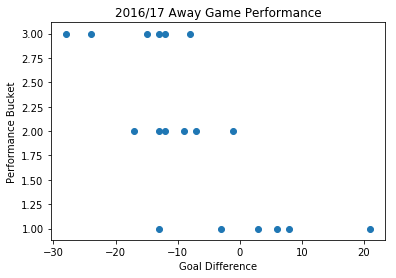

In [83]:
all_gd = all[['AwayTeam','GD']].groupby('AwayTeam', axis=0).sum()
#all_gd.sort_values(by=['AwayTeam'], inplace=True)

all_gd_1 = all[['AwayTeam','Away_Perform_Bucket']].groupby('AwayTeam', axis=0).mean()

plt.ylabel('Performance Bucket')
plt.xlabel('Goal Difference')
plt.title('2016/17 Away Game Performance')

plt.scatter(all_gd['GD'], all_gd_1['Away_Perform_Bucket'])
plt.show()

### As suspected, bad teams were scored on quite a lot in away games. Average teams had a net negative goal difference in away games as well. This is no surprise since everyone knows away games are brutal. The interesting piece to me is that there were a couple of good performing teams who fared worse in away games than average teams. In fact, one of the good teams (Borussia Monchengladbach) performed worse in away games than most average teams and even a couple of bad teams. They must have won a lot of home games!